In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import optax
import tqdm
import functools

# Learning Rate Scheduling

Part of the traditional machine learning recipe is to decay our learning rate (LR) over time. This ensures that we get fast learning early on, but can get that last push of performance near the edge. Let's see how much this matters, and if we can get away without it.

## Classical Optimization: Decay your learning rate

In classical optimization theory, learning rate must decay for us to get certain convergence guarantees. The intution is that if we stay at a constant learning rate forever, we'll end up bouncing around the optimum and won't converge to the exact point. By decaying the change to zero, we will eventually converge to a fixed point at minimum loss.

Of course, it's one thing for a technique to be theoretically sound, and other for it to work in practice...

## Experiment: Learning rate decay with CIFAR-10

Let's try out some differnt learning rate schedules on neural networks. We'll use the CIFAR-10 dataset this time, which is a set of 50,000 colored images and 10 classes. We'll use a simple small convolutional network, and the Adam optimizer.

Dataset size: (50000, 32, 32, 3)


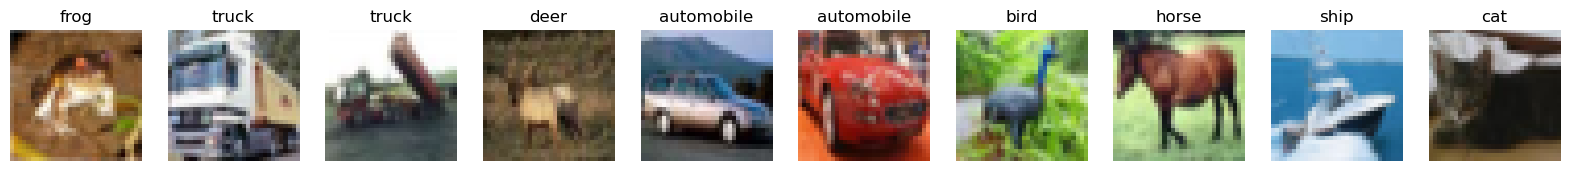

In [4]:
from keras.datasets import cifar10
(train_images, train_labels), (valid_images, valid_labels) = cifar10.load_data()
id_to_text = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Dataset size:', train_images.shape)

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(train_images[i], cmap='gray')
    ax.title.set_text(f'{id_to_text[train_labels[i][0]]}')
    ax.axis('off')

In [5]:
# From https://github.com/young-geng/m3ae_public/blob/master/m3ae/model.py
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = jnp.arange(embed_dim // 2, dtype=jnp.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = jnp.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = jnp.sin(out) # (M, D/2)
    emb_cos = jnp.cos(out) # (M, D/2)

    emb = jnp.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_1d_sincos_pos_embed(embed_dim, length):
    emb = get_1d_sincos_pos_embed_from_grid(embed_dim, jnp.arange(length, dtype=jnp.float32))
    return jnp.expand_dims(emb,0)

def get_2d_sincos_pos_embed(embed_dim, length):
    # example: embed_dim = 256, length = 16*16
    grid_size = int(length ** 0.5)
    assert grid_size * grid_size == length
    def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
        assert embed_dim % 2 == 0
        # use half of dimensions to encode grid_h
        emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
        emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
        emb = jnp.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
        return emb

    grid_h = jnp.arange(grid_size, dtype=jnp.float32)
    grid_w = jnp.arange(grid_size, dtype=jnp.float32)
    grid = jnp.meshgrid(grid_w, grid_h)  # here w goes first
    grid = jnp.stack(grid, axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return jnp.expand_dims(pos_embed, 0) # (1, H*W, D

In [6]:
from einops import rearrange

class TinyViT(nn.Module):
    features: int = 128
    patch_size: int = 4
    num_classes: int = 10
    dropout: float = 0.3

    @nn.compact
    def __call__(self, x, deterministic=False):
        patch_tuple = (self.patch_size, self.patch_size)
        num_patches = (x.shape[1] // self.patch_size)
        x = nn.Conv(self.features, patch_tuple, patch_tuple, use_bias=True, padding="VALID")(x) # Patch Embed
        x = rearrange(x, 'b h w c -> b (h w) c', h=num_patches, w=num_patches)
        x = x + get_2d_sincos_pos_embed(self.features, num_patches**2)
        x = jnp.concatenate([x, nn.Embed(1, self.features)(jnp.zeros((x.shape[0], 1), dtype=jnp.int32))], axis=1) # Class Token
        for _ in range(4):
            y = nn.LayerNorm()(x)
            y = nn.MultiHeadDotProductAttention(num_heads=4, dropout_rate=self.dropout, deterministic=deterministic)(y, y)
            x = x + y
            y = nn.LayerNorm()(x)
            y = nn.Dense(self.features * 2)(y)
            y = nn.gelu(y)
            y = nn.Dropout(rate=self.dropout, deterministic=deterministic)(y)
            y = nn.Dense(self.features)(y)
            y = nn.Dropout(rate=self.dropout, deterministic=deterministic)(y)
            x = x + y
        x = x[:, 0]
        x = nn.Dense(self.num_classes)(x)
        return x

def sample_batch(key, batchsize, images, labels):
    idx = jax.random.randint(key, (batchsize,), 0, images.shape[0])
    return images[idx], labels[idx]

def train_cifar(lr_function, max_steps, averaging_fn=None):
    train_losses, valid_losses, train_accuracies, valid_accuracies = [], [], [], []
    classifier = TinyViT()
    key = jax.random.PRNGKey(0)
    key, param_key = jax.random.split(key)
    v_images, v_labels = sample_batch(param_key, 1024, valid_images, valid_labels)
    params = classifier.init({'params': param_key, 'dropout': param_key}, v_images)['params']
    avg_params = params
    tx = optax.adamw(lr_function, weight_decay=0.1)
    opt_state = tx.init(params)
    @functools.partial(jax.jit, static_argnums=(5,))
    def update_fn(key, params, opt_state, images, labels, deterministic=False):
        def loss_fn(p, x, y):
            x = x / 255.0
            onehot_labels = jax.nn.one_hot(y[:, 0], 10)
            logits = classifier.apply({'params': p}, x, rngs={'dropout': key}, deterministic=deterministic)
            loss = jnp.mean(jnp.sum(-nn.log_softmax(logits) * onehot_labels, axis=-1))
            accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y[:, 0])
            return loss, accuracy
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, accuracy), grads = grad_fn(params, images, labels)
        updates, opt_state = tx.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, accuracy, params, opt_state
    for i in tqdm.tqdm(range(max_steps)):
        key, data_key, update_key = jax.random.split(key, 3)
        images, labels = sample_batch(data_key, 256, train_images, train_labels)
        loss, accuracy, params, opt_state = update_fn(update_key, params, opt_state, images, labels, False)
        if averaging_fn is not None:
            avg_params = averaging_fn(avg_params, params, i)
            loss, accuracy, _, _ = update_fn(update_key, avg_params, opt_state, images, labels, False)
        if i % 100 == 0:
            valid_loss, valid_accuracy, _, _ = update_fn(update_key, params, opt_state, v_images, v_labels, True)
            valid_losses.append(np.array(valid_loss))
            valid_accuracies.append(np.array(valid_accuracy))
        train_losses.append(np.array(loss))
        train_accuracies.append(np.array(accuracy))
    # return np.array(train_losses), np.array(valid_losses), np.array(train_accuracies), np.array(valid_accuracies)
    return np.array(train_losses)

def plot_losses(losses, labels, title):
    fig, axs = plt.subplots(1, figsize=(5, 3))
    for label, loss in zip(labels, losses):
        loss = np.convolve(loss, np.ones(100), 'valid') / 100
        axs.plot(loss, label=label)
    axs.legend()
    axs.set_ylim(0, 2)
    axs.set_title(title)
    plt.show()

In [ ]:
constant_loss = train_cifar(lambda x: 0.001, 20000)
linear_losses = []
for max_steps in [20000, 15000, 10000, 5000]:
    linear_losses.append(train_cifar(lambda x: 0.001 * (1 - (x / max_steps)), max_steps))

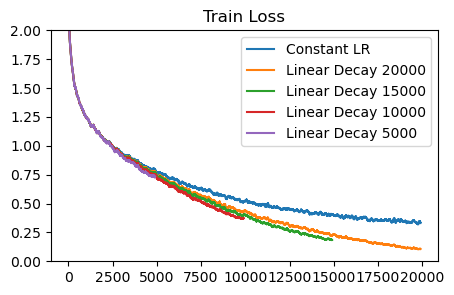

In [99]:
plot_losses([constant_loss] + linear_losses, 
            ['Constant LR'] + [f'Linear Decay {d}' for d in [20000, 15000, 10000, 5000]], 'Train Loss')

**Learning rate decay consistently helps**. As as baseline, the blue 'Constant LR' curve shows us what happens when we just use a fixed learning rate. The network is still improving, and there's definitely progress being made at every step. However, we get a consistent gain from using **linear decay**, where we simply scale the LR down linearly until it reaches zero at the end of training.

Does the *type* of decay matter? Let's try out **cosine decay**, which decays LR following the first cycle of a cosine. We'll also try out a simple **stepwise decay**, which uses a constant learning rate for most of training, then drops to a lower rate near the end.

In [104]:
cosine_loss = train_cifar(lambda x: 0.001 * (0.5 * (1 + jnp.cos(jnp.pi * (x / 20000)))), 20000)
stepwise_loss = train_cifar(lambda x: jnp.where(x > 15000, 0.0001, 0.001), 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

(256, 32, 32, 3) (256, 10) (256, 1) (256, 10)


(1024, 32, 32, 3) (1024, 10) (1024, 1) (1024, 10)



100%|██████████| 20000/20000 [02:34<00:00, 129.57it/s]


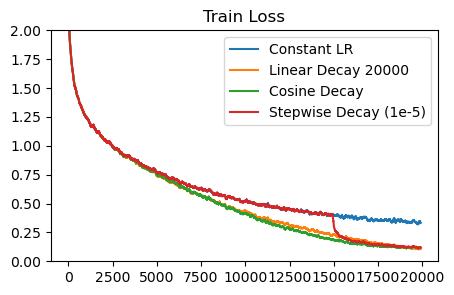

In [107]:
plot_losses([constant_loss, linear_losses[0], cosine_loss, stepwise_loss], 
            ['Constant LR', 'Linear Decay 20000', 'Cosine Decay', 'Stepwise Decay (1e-5)'], 'Train Loss')

So, it seems that the decay schedule itself doesn't matter, but rather *the fact that decay happens at all* is important. The stepwise decay shows the most interesting finding. Even with a constant LR, we're still making learning progress -- it's just that we haven't fully realized the gains yet. Let's refer to the parameters achieving the lower loss as the **smoothed** parameters. Training with a high LR is good for making progress, but it doesn't fully smooth the parameters -- we need to decay.

## An alterative: Parameter Averaging

A natural question asks, **is there a way to have smoothed parameters throughout the entire training run**? 
A key intution is a relationship between LR decay and parameter averaging. Intuitively, when training with a high LR, some parameters may oscillate. A slower LR lets these parameters properly converge to their smoothed values. Another way we can achieve this is through **parameter averaging** -- i.e, we use an *average of past parameters* rather than the current ones. This lets oscillations cancel out.

Linear LR decay is in fact quite similar to uniform averaging with a constant LR. Imagine applying a gradient halfway through training. With linear LR decay, we apply the gradient at half magnitude. With uniform averaging, that gradient is present in the *last half* of the parameter sequence, giving it a half-weighting in the final average. The difference of course is where the gradient is calculate -- with linear LR decay, we calculate on the *smoothed* parameters, wheras with parameter averaging, we calculate on the *live* parameters.

Let's plot some runs where we use parameter averaging. We will try two standard strategies -- **Polyak (uniform) averaging**, which assigns equal weight to all past parameters, and **exponential moving averaging**, which values recent parameters more.

In [ ]:
def polyak_avg(avg_params, params, steps):
    c = 1 / (steps + 1)
    return jax.tree_map(lambda x, y: x * (1-c) + y * c, avg_params, params)
polyak_loss = train_cifar(lambda x: 0.001, 20000, jax.jit(polyak_avg))

def exponential_avg(avg_params, params, steps):
    return jax.tree_map(lambda x, y: x * 0.999 + y * 0.001, avg_params, params)
exponential_loss = train_cifar(lambda x: 0.001, 20000, jax.jit(exponential_avg))


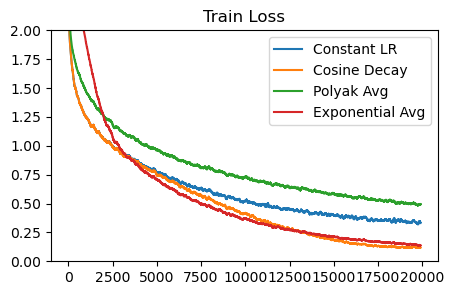

In [123]:
plot_losses([constant_loss, cosine_loss, polyak_loss, exponential_loss], 
            ['Constant LR', 'Cosine Decay', 'Polyak Avg', 'Exponential Avg'], 'Train Loss')

Interestingly, it seems like exponential averaging is quite powerful, almost as much as cosine LR decay. Polyak averaging isn't as good -- it actually lags behind the non-averaging baseline. Perhaps this is because of bias that is introduced from weighting earlier parameters equally? At the limit, polyak averaging will converge to the proper smoothed parameters, but it may take a long time in practice.

## Schedule-Free Optimization

Taking our connection between LR decay and parameter averaging, we can understand the insights behind **schedule-free optimization** ([Defazio 2024](https://arxiv.org/pdf/2405.15682)). The core of their proposed method is to keep track of smoothed parameters using parameter averaging. When calculating the gradient, we calculate using a *linear combination* of the live and smoothed parameters. 

```
combo_params = (1-b) * live_params + b * smooth_params
live_params = live_params + grad(combo_params)
smooth_params = (1-c) * smooth_params + c * live_params (Polyak averaging)
```

The intution is to generalize the two approaches we had before (LR decay and parameter averaging). Instead of evaluating the gradient at either the smoothed or live parameters, we use a middle ground between them. `b` is usually a high value (0.9), so we're mostly using the smoothed parameters.

In [10]:
def train_cifar_schedulefree(lr_function, max_steps, average_type='polyak'):
    train_losses, valid_losses, train_accuracies, valid_accuracies = [], [], [], []
    classifier = TinyViT()
    key = jax.random.PRNGKey(0)
    key, param_key = jax.random.split(key)
    v_images, v_labels = sample_batch(param_key, 1024, valid_images, valid_labels)
    params = classifier.init({'params': param_key, 'dropout': param_key}, v_images)['params']
    smooth_params = params
    tx = optax.adamw(lr_function, weight_decay=0.1)
    opt_state = tx.init(params)
    @functools.partial(jax.jit, static_argnums=(6,))
    def update_fn(key, params, smooth_params, opt_state, images, labels, deterministic=False):
        def loss_fn(p, x, y):
            x = x / 255.0
            onehot_labels = jax.nn.one_hot(y[:, 0], 10)
            logits = classifier.apply({'params': p}, x, rngs={'dropout': key}, deterministic=deterministic)
            loss = jnp.mean(jnp.sum(-nn.log_softmax(logits) * onehot_labels, axis=-1))
            accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y[:, 0])
            return loss, accuracy
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        combo_params = jax.tree_map(lambda x, y: 0.9 * x + 0.1 * y, smooth_params, params)
        (loss, accuracy), grads = grad_fn(combo_params, images, labels)
        updates, opt_state = tx.update(grads, opt_state, combo_params)
        params = optax.apply_updates(params, updates)
        if average_type == 'polyak':
            c = 1 / (i + 1)
            smooth_params = jax.tree_map(lambda x, y: (1-c) * x + c * y, smooth_params, params)
        elif average_type == 'exponential':
            smooth_params = jax.tree_map(lambda x, y: 0.999 * x + 0.001 * y, smooth_params, params)
        return loss, accuracy, params, opt_state
    for i in tqdm.tqdm(range(max_steps)):
        key, data_key, update_key = jax.random.split(key, 3)
        images, labels = sample_batch(data_key, 256, train_images, train_labels)
        loss, accuracy, params, opt_state = update_fn(update_key, params, smooth_params, opt_state, images, labels, False)
        train_losses.append(np.array(loss))
        train_accuracies.append(np.array(accuracy))
    return np.array(train_losses)

In [11]:
schedulefree_polyak_loss = train_cifar_schedulefree(lambda x: 0.001, 20000, 'polyak')
schedulefree_exponential_loss = train_cifar_schedulefree(lambda x: 0.001, 20000, 'exponential')


  0%|          | 0/20000 [00:00<?, ?it/s]warning: Linking two modules of different target triples: 'LLVMDialectModule' is 'nvptx64-nvidia-gpulibs' whereas '' is 'nvptx64-nvidia-cuda'

  0%|          | 0/20000 [00:00<?, ?it/s]warning: Linking two modules of different target triples: 'LLVMDialectModule' is 'nvptx64-nvidia-gpulibs' whereas '' is 'nvptx64-nvidia-cuda'

100%|██████████| 20000/20000 [02:32<00:00, 130.91it/s]


[4.673369   4.124187   3.941955   ... 0.7432178  0.70011115 0.7734933 ]
[4.673369   4.124187   3.941955   ... 0.7429756  0.70004845 0.7735711 ]


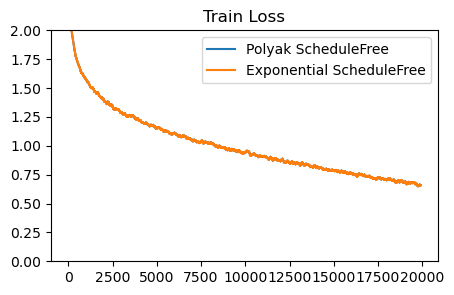

In [15]:
print(schedulefree_polyak_loss)
print(schedulefree_exponential_loss)
plot_losses([schedulefree_polyak_loss, schedulefree_exponential_loss], 
            ['Polyak ScheduleFree', 'Exponential ScheduleFree'], 'Train Loss')